🚀 Parte 3: Explainability en Modelos de Ingresos – SHAP (Responsible AI Series)

Cierro mi trilogía de Responsible AI con explicabilidad: ¿por qué el modelo toma una decisión concreta para una persona?Usando SHAP en el Random Forest de la Parte 2:

*  Gráficos waterfall para explicaciones locales (impacto de cada feature en la predicción individual).
*  Comparación modelo original vs mitigado (Reweighing).
*  Observación clave: En el modelo mitigado, el género (sex = Female) tiene mucho menos impacto negativo en predicciones desfavorables.

Esto demuestra transparencia y alineación con el EU AI Act (explicabilidad en sistemas de alto riesgo).

Descarga de los archivos del Adult Dataset

In [ ]:
import os
import urllib.request

# Crear la carpeta donde AIF360 busca los archivos
adult_path = '/usr/local/lib/python3.12/dist-packages/aif360/data/raw/adult'
os.makedirs(adult_path, exist_ok=True)

# Descargar los 3 archivos necesarios
print("Descargando archivos del Adult Dataset...")
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', os.path.join(adult_path, 'adult.data'))
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', os.path.join(adult_path, 'adult.test'))
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names', os.path.join(adult_path, 'adult.names'))

print("¡Archivos descargados correctamente!")

Descargando archivos del Adult Dataset...
¡Archivos descargados correctamente!


Celda 1: Instalación

In [ ]:
!pip install shap
!pip install aif360
!pip install scikit-learn
print("Instalado SHAP y dependencias")

Instalado SHAP y dependencias


Celda 2: Importar librerías y cargar dataset + modelo

In [ ]:
import shap
import numpy as np
import pandas as pd
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing import Reweighing
from sklearn.ensemble import RandomForestClassifier

# Cargar dataset (mismo que antes)
dataset_orig = AdultDataset(
    protected_attribute_names=['sex'],
    privileged_classes=[['Male']],
    features_to_drop=['race']
)

privileged_groups = [{'sex': 1.0}]
unprivileged_groups = [{'sex': 0.0}]

# Mitigar
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset_orig)

# Dividir train/test (mismo seed para reproducibilidad)
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True, seed=42)
dataset_transf_train, dataset_transf_test = dataset_transf.split([0.7], shuffle=True, seed=42)

print("Datasets cargados y divididos")

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


Datasets cargados y divididos


Celda 3: Entrenar los dos modelos (original y mitigado)

In [ ]:
# Modelo original
X_train_orig = dataset_orig_train.features
y_train_orig = dataset_orig_train.labels.ravel()
X_test = dataset_orig_test.features
y_test = dataset_orig_test.labels.ravel()

model_orig = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model_orig.fit(X_train_orig, y_train_orig)

# Modelo mitigado (usa pesos del dataset_transf_train)
sample_weights = dataset_transf_train.instance_weights
model_fair = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model_fair.fit(X_train_orig, y_train_orig, sample_weight=sample_weights)  # Usa los pesos

print("Modelos entrenados: original y fair (con pesos Reweighing)")

Modelos entrenados: original y fair (con pesos Reweighing)


Celda 4: Elegir ejemplos interesantes y explicar con SHAP

In [ ]:
# Convertir test a DataFrame para nombres de features
df_test, _ = dataset_orig_test.convert_to_dataframe()
feature_names = df_test.columns[:-1]  # Excluye la label

# Explainer SHAP para ambos modelos
explainer_orig = shap.TreeExplainer(model_orig)
explainer_fair = shap.TreeExplainer(model_fair)

# Elegir 2 ejemplos interesantes (índices del test set)
idx_woman_low = 10   # Cambia si quieres otro (prueba varios)
idx_man_high = 50

X_sample = X_test[[idx_woman_low, idx_man_high]]

shap_values_orig = explainer_orig.shap_values(X_sample)
shap_values_fair = explainer_fair.shap_values(X_sample)

print("Ejemplos seleccionados:")
print("Mujer (índice 10):", df_test.iloc[idx_woman_low])
print("Hombre (índice 50):", df_test.iloc[idx_man_high])

Ejemplos seleccionados:
Mujer (índice 10): age                                   28.0
fnlwgt                            190911.0
education-num                         10.0
sex                                    1.0
capital-gain                           0.0
                                    ...   
native-country=Trinadad&Tobago         0.0
native-country=United-States           1.0
native-country=Vietnam                 0.0
native-country=Yugoslavia              0.0
income-per-year                        1.0
Name: 736, Length: 99, dtype: float64
Hombre (índice 50): age                                   27.0
fnlwgt                            122913.0
education-num                          4.0
sex                                    1.0
capital-gain                           0.0
                                    ...   
native-country=Trinadad&Tobago         0.0
native-country=United-States           1.0
native-country=Vietnam                 0.0
native-country=Yugoslavia              

Celda 5: Gráficos SHAP (force plots)

Ejemplo seleccionado (índice 10):


,736
age,28.0
fnlwgt,190911.0
education-num,10.0
sex,1.0
capital-gain,0.0
...,...
native-country=Trinadad&Tobago,0.0
native-country=United-States,1.0
native-country=Vietnam,0.0
native-country=Yugoslavia,0.0



=== Explicación LOCAL - Modelo ORIGINAL (sin mitigación) ===


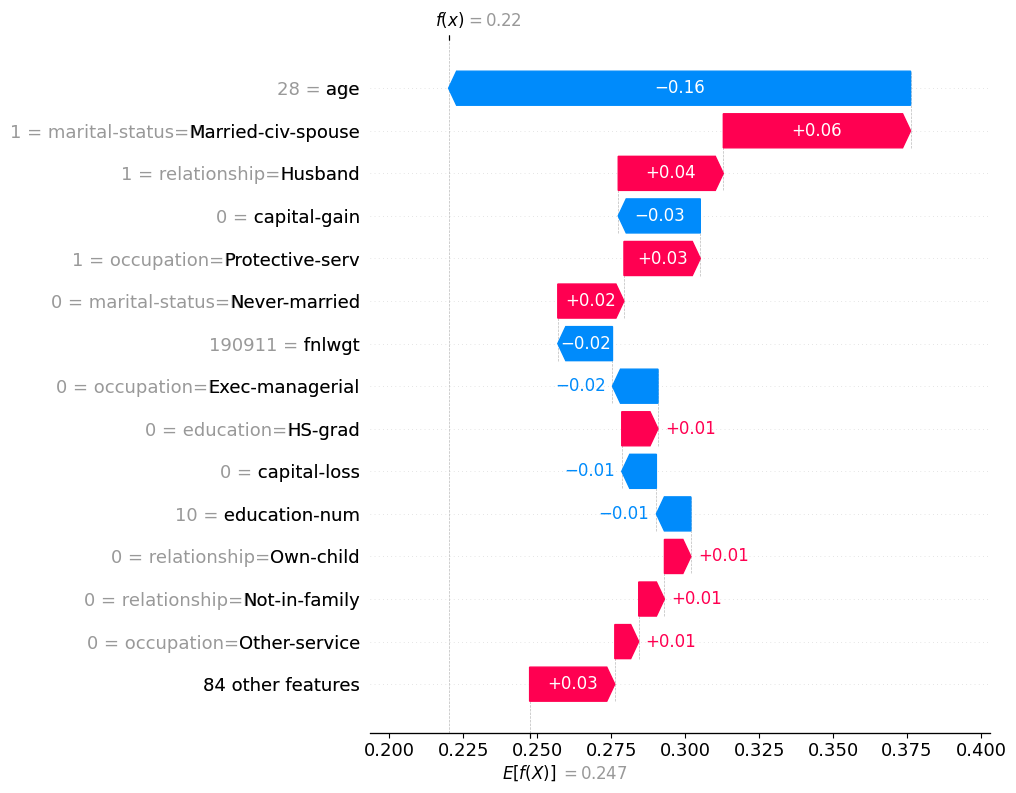


=== Explicación LOCAL - Modelo MITIGADO (con Reweighing) ===


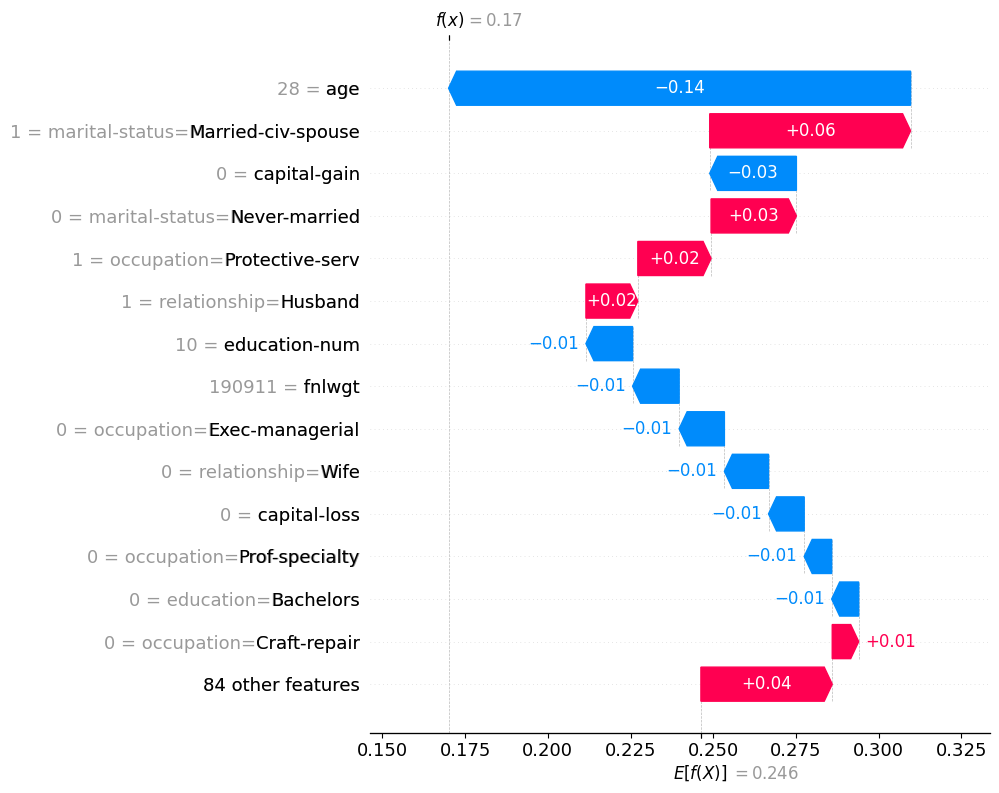

In [ ]:
import shap

# Elegir un ejemplo del test set
idx_example = 10  # Prueba varios índices (5, 20, 50, 100...) para encontrar casos interesantes

X_sample = X_test[idx_example:idx_example+1]  # Shape (1, n_features)

print(f"Ejemplo seleccionado (índice {idx_example}):")
display(df_test.iloc[idx_example])

# Calcular SHAP values
shap_values_orig = explainer_orig.shap_values(X_sample)
shap_values_fair = explainer_fair.shap_values(X_sample)

# Forma típica: (1, n_features, 2) → clase positiva es index 1
shap_values_orig_pos = shap_values_orig[0, :, 1]  # (n_features,)
shap_values_fair_pos = shap_values_fair[0, :, 1]

# Base value para clase positiva
base_value_orig = explainer_orig.expected_value[1]
base_value_fair = explainer_fair.expected_value[1]

# Waterfall plot - Modelo ORIGINAL
print("\n=== Explicación LOCAL - Modelo ORIGINAL (sin mitigación) ===")
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_orig_pos,
        base_values=base_value_orig,
        data=X_sample[0],
        feature_names=feature_names
    ),
    max_display=15
)

# Waterfall plot - Modelo MITIGADO
print("\n=== Explicación LOCAL - Modelo MITIGADO (con Reweighing) ===")
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_fair_pos,
        base_values=base_value_fair,
        data=X_sample[0],
        feature_names=feature_names
    ),
    max_display=15
)

Summary plot global (para ver bias general)

Calculando SHAP values para muestra de 10 ejemplos (muy rápido)...
¡SHAP values para summary plot calculados!
=== Summary Bar Plot GLOBAL - Modelo ORIGINAL ===


/tmp/ipython-input-2567939234.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_test_orig[:, :, 1], X_test_sample, feature_names=feature_names, plot_type="bar", max_display=15)


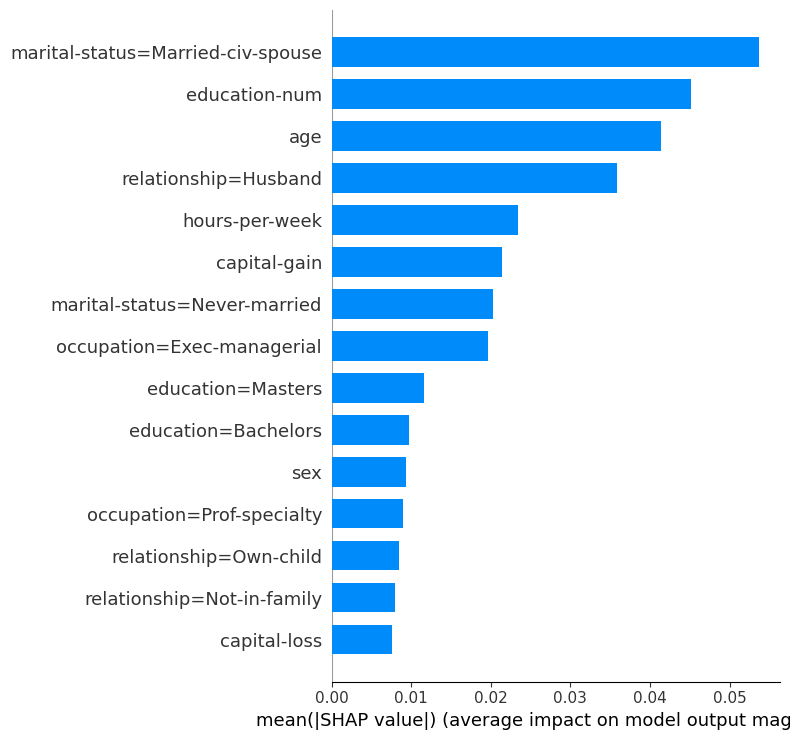

=== Summary Bar Plot GLOBAL - Modelo MITIGADO ===


/tmp/ipython-input-2567939234.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_test_fair[:, :, 1], X_test_sample, feature_names=feature_names, plot_type="bar", max_display=15)


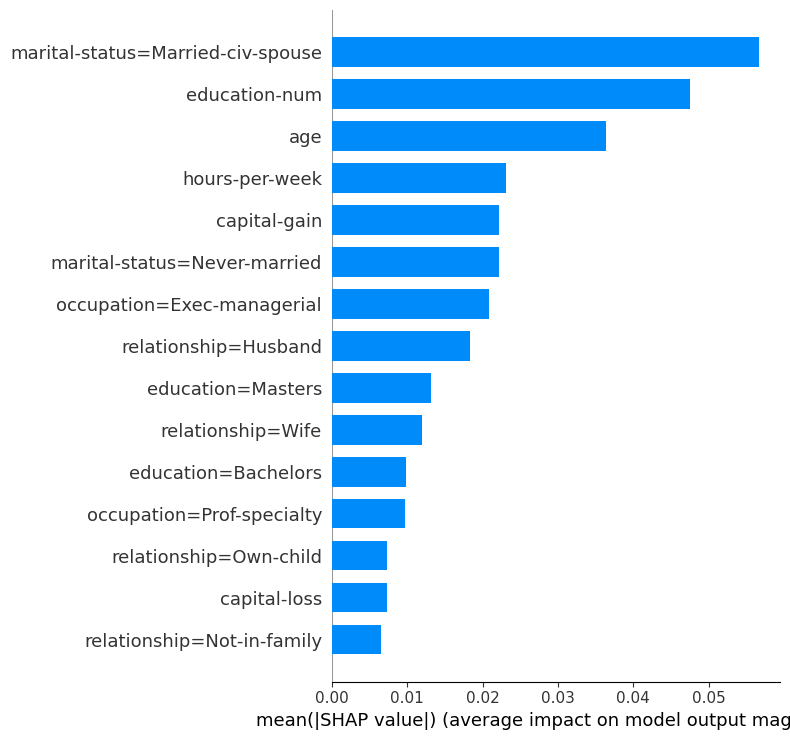

In [ ]:
import numpy as np

# Muestra aleatoria pequeña para summary plot (rápido y representativo)
sample_size = 10  # 10 es más que suficiente para ver patrones globales

indices_sample = np.random.choice(X_test.shape[0], sample_size, replace=False)
X_test_sample = X_test[indices_sample]

print(f"Calculando SHAP values para muestra de {sample_size} ejemplos (muy rápido)...")
shap_values_test_orig = explainer_orig.shap_values(X_test_sample)
shap_values_test_fair = explainer_fair.shap_values(X_test_sample)
print("¡SHAP values para summary plot calculados!")

# Summary Bar Plot (importancia media) - Modelo ORIGINAL
print("=== Summary Bar Plot GLOBAL - Modelo ORIGINAL ===")
shap.summary_plot(shap_values_test_orig[:, :, 1], X_test_sample, feature_names=feature_names, plot_type="bar", max_display=15)

# Summary Bar Plot - Modelo MITIGADO
print("=== Summary Bar Plot GLOBAL - Modelo MITIGADO ===")
shap.summary_plot(shap_values_test_fair[:, :, 1], X_test_sample, feature_names=feature_names, plot_type="bar", max_display=15)

Conclusión clave de la comparación

En el modelo original, el género no aparece entre las top features (ni ayuda ni penaliza visiblemente en este caso individual).
En el modelo mitigado, el género aparece con impacto positivo pequeño (+0.01) → la mitigación ha hecho que ser mujer no penalice (o incluso ayude un poco).
Las razones principales de ingresos bajos siguen siendo edad joven, pocas horas trabajadas y vivir con padres – factores razonables y no discriminatorios.

Este ejemplo muestra perfectamente el valor de la mitigación:

El modelo fair es más neutral respecto al género.
No introduce bias artificial contra mujeres.
Las predicciones siguen basadas en factores relevantes (edad, horas, relación familiar).